In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import interpolate

sns.set_style("whitegrid")

In [2]:
def label_to_title(label):
    tmp = label.split("_")
    ans = ""
    for i in range(len(tmp)):
        tmp_ = tmp[i].title()
        ans += tmp_ + " "
    return ans[:-1]
    
label_to_title("average_score")

'Average Score'

In [3]:
def plot_results(dir_name_list, label_list, title=None, n_exp=5, fontsize=28, ticksize=20, max_index=None, yscale="linear", xscale="linear", interpolate=False, filename=None):
    
    key_list = ["total_steps", "best_score"]
    
    # loading dataframe
    stats = {}
    for dir_name in dir_name_list:
        
        stats[dir_name] = {}
        for key in key_list:
            stats[dir_name][key] = []

        for subdir, _, _ in os.walk(dir_name):
            
            for file in os.listdir(subdir):
                
                if not file.endswith('log.pkl'):
                    continue

                df = pd.read_pickle(subdir + "/" + file)
                for key in key_list:
                    try:
                        tmp = df[key].tolist()
                        stats[dir_name][key].append(tmp)
                    except:
                        print("key not in df")
                        return
                
    
    n = len(key_list)
        
    """
    Display the graph of the corresponding measure
    """

    plt.figure(figsize=(15, 8))
    plt.title(title, fontsize=fontsize)
    plt.tick_params(axis='both', which='major', labelsize=ticksize)
    plt.tick_params(axis='both', which='minor', labelsize=ticksize)
    
    plt.xlabel("Number of steps", fontsize=fontsize)
    plt.ylabel(label_to_title(key), fontsize=fontsize)
    plt.yscale(yscale)
    plt.xscale(xscale)

    sns.set_palette("gnuplot", len(dir_name_list)) 
    
    cpt_ = 0
    for dir_name in dir_name_list:
        
        if interpolate:
            
            absc = np.array(stats[dir_name]["total_steps"])
            score = np.array(stats[dir_name]["best_score"])
            data = [(x, y) for x, y in zip(absc, score)]

            # This is the minimum and maximum from all the datapoints.
            xmin = min(np.min(line[0]) for line in data)
            xmax = max(np.max(line[0]) for line in data)

            #100 points evenly spaced along the x axis
            x_points = np.linspace(xmin, xmax)

            #interpolate your values to the evenly spaced points.
            interpolated = [np.interp(x_points, d[0], d[1]) for d in data]

            #Now do the averaging.
            mean = [np.mean(x) for x in zip(*interpolated)]
            median = [np.median(x) for x in zip(*interpolated)]
            std = [np.std(x) for x in zip(*interpolated)]

            plt.plot(x_points, mean, label=label_list[cpt_], linewidth=2.0, color=sns.color_palette()[cpt_])
            plt.fill_between(x_points, mean-std/np.sqrt(n_exp), mean+std/np.sqrt(n_exp), alpha=0.2)
            plt.plot(x_points, median, linestyle='-.', linewidth=2.0, color=sns.color_palette()[cpt_])
            
        else:
            
            mean = np.mean(stats[dir_name]["best_score"], axis=1)
            median = np.median(stats[dir_name]["best_score"], axis=1)
            std = np.std(stats[dir_name]["best_score"], axis=1)
            
            plt.plot(stats[dir_name]["total_steps"][0], mean, label=label_list[cpt_], linewidth=2.0, color=sns.color_palette()[cpt_])
            plt.fill_between(stats[dir_name]["total_steps"][0], mean-std/np.sqrt(n_exp), mean+std/np.sqrt(n_exp), alpha=0.2)
            plt.plot(stats[dir_name]["total_steps"][0], median, linestyle='-.', linewidth=2.0, color=sns.color_palette()[cpt_])

        cpt_ += 1

    legend = plt.legend(fontsize=fontsize)
    for legobj in legend.legendHandles:
        legobj.set_linewidth(3.0) 

    if filename is not None:
        plt.savefig(key + "_" + filename, bbox_inches='tight', pad_inches=0)
    plt.show()

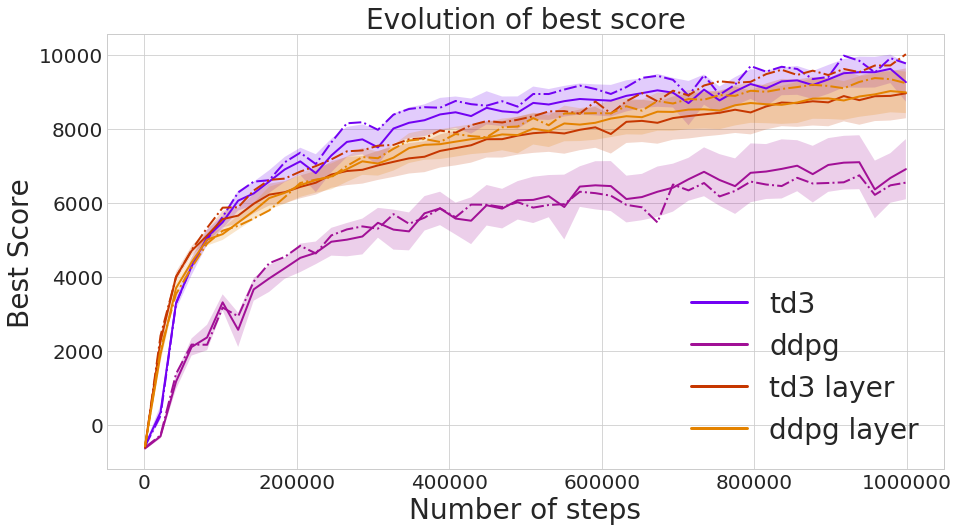

In [5]:
dir_name_list = [
        "td3_gauss/",
        "ddpg_gauss/",
        "td3_layer_gauss/",
        "ddpg_layer_gauss",
]

label_list = ["td3", "ddpg", "td3 layer", "ddpg layer"]
plot_results(dir_name_list, label_list, n_exp=10, yscale="linear", interpolate=True, title="Evolution of best score")